# A demo of K-Means clustering on the handwritten digits data
In this example we compare the various initialization strategies for K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see Clustering performance evaluation for definitions and discussions of the metrics):

| Shorthand | full name |
|:- | -: |
| homohomogeneity | score |
| compl |  completeness score |
| v-meas | V measure |
| ARI | adjusted Rand index |
| AMI | adjusted mutual information |
| silhouette | silhouette coefficient |

<b>data source</b>

example that visualizes the data clusters and their centers using K-means, check out the sklearn‘s [own example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).

## Load the Data
This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
print(data, labels)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] [0 1 2 ... 8 9 8]


In [4]:
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"# digits : {n_digits}, # samples : {n_samples}, # features : {n_features}")

# digits : 10, # samples : 1797, # features : 64


## Define Evaluation Benchmark
first evaluation our benchmark. This benhcmark, intend to compare different initalization methods for KMeans.

Our bencmark will:
- create a pipeline which will scale the data using a StandardScaler;
- train and time the pipeline fitting;
- measure the performance of the clustering obtained via different metrics.

In [13]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    
    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Run the Benchmark
compare three approaches:

- an initialization using kmeans++. This method is stochastic and we will run the initialization 4 times;
- a random initialization. This method is stochastic as well and we will run the initialization 4 times;
- an initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. This method is deterministic and a single initialization suffice.

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhoutte")

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="pca-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhoutte
k-means++	0.115s	69662	0.680	0.719	0.699	0.570	0.695	0.171
random   	0.079s	69707	0.675	0.716	0.694	0.560	0.691	0.171
pca-based	0.030s	72686	0.636	0.658	0.647	0.521	0.643	0.139
__________________________________________________________________________________


## Visualize the results on PCA-reduced data
PCA allows to project the data from the original 64-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

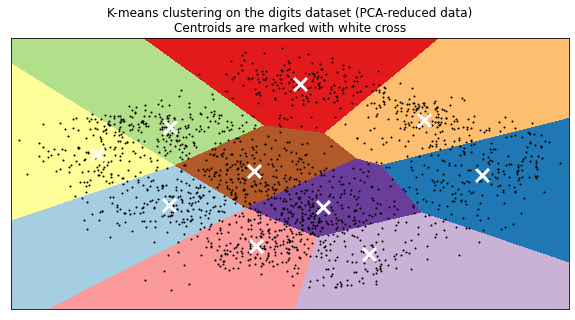

In [27]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4)
kmeans.fit(reduce_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02 # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:,0].min() - 1, reduced_data[:,0].max() + 1
y_min, y_max = reduced_data[:,0].min() - 1, reduced_data[:,0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,5))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower"
)

plt.plot(reduced_data[:,0], reduced_data[:,1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:,0],
    centroids[:,1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()